---
title: "Asset Allocation & Investment Strategies - 2nd Assignment"
author:
  - Group 1
  - Azim Balci, Mayeul Perret, Rodolphe Lajugie, Theodosis Kaplanidis, Zihua Du
date: "2026-02-02"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

## Importing Python Libraries and Statistical Packages

In [17]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re

## Data Description and Loading


In this section, we load the two datasets used throughout the analysis.

The first dataset contains the monthly Fama–French risk factors and the risk-free rate.  It provides the market excess return (Mkt_RF), the size factor (SMB), the value factor (HML), and the one-month risk-free rate (RF). These variables are used as explanatory factors in the asset pricing regressions.

The second dataset contains the monthly excess returns of the 25 Fama–French portfolios formed on size and book-to-market equity. We focus on value-weighted portfolio returns, which serve as the dependent variables in the time-series regressions.

In [2]:
# Load value-weighted monthly portfolio returns
portfolios_vw = pd.read_excel(
    "25_Portfolios_5x5_clean.xlsx",
    sheet_name="VW Returns Monthly")

# Clean header structure
portfolios_vw = portfolios_vw.iloc[1:].reset_index(drop=True)
portfolios_vw.columns = portfolios_vw.iloc[0]
portfolios_vw = portfolios_vw.iloc[1:].reset_index(drop=True)
portfolios_vw["Date"] = pd.to_datetime(portfolios_vw["Date"])

# Convert portfolio returns from percent to decimal
portfolio_cols = [col for col in portfolios_vw.columns if col != "Date"]
for col in portfolio_cols:
    portfolios_vw[col] = pd.to_numeric(portfolios_vw[col]) / 100

# Load Fama-French factors data
ff_factors = pd.read_excel(
    "F-F_Research_Data_Factors_clean.xlsx",
    sheet_name="Monthly Excess Returns")

# Merge portfolios with risk-free rate
data = portfolios_vw.merge(
    ff_factors[["Date", "RF"]],
    on="Date",
    how="inner")

# Compute excess returns for each portfolio
for col in portfolio_cols:
    data[col] = data[col] - data["RF"]

# Keep excess portfolio returns only
excess_portfolios = data.drop(columns=["RF"])

## Sample Period and Data Preparation for the CAPM

We begin by evaluating the performance of the single-factor CAPM over the sample period studied by Fama and French (1993). Following the original analysis, we restrict the data to the period from January 1964 to January 1993.

The excess returns of the 25 Fama–French portfolios and the market excess return are used as inputs in the subsequent time-series regressions.

In [3]:
# Define sample period
start_date = "1964-01-01"
end_date = "1993-01-01"

# Restrict portfolio excess returns to the sample period
excess_portfolios_sample = excess_portfolios[
    (excess_portfolios["Date"] >= start_date) &
    (excess_portfolios["Date"] <= end_date)
].reset_index(drop=True)

# Restrict factor data to the same sample period
ff_factors_sample = ff_factors[
    (ff_factors["Date"] >= start_date) &
    (ff_factors["Date"] <= end_date)
].reset_index(drop=True)

# Keep market excess return only for CAPM
mkt_excess = ff_factors_sample[["Date", "Mkt_RF"]]

## Question i

We evaluate the performance of the single-factor CAPM by estimating, for each of the 25 Fama–French portfolios, the following time-series regression over the period January 1964 to January 1993:

$$
r_{i,t} = \alpha_i + \beta_i \, Mkt\_RF_t + \varepsilon_{i,t},
$$

where $r_{i,t}$ denotes the excess return on portfolio $i$ and $Mkt\_RF_t$ is the market excess return. For each portfolio, we report the mean excess return, the estimated CAPM beta and its t-statistic, the estimated alpha and its t-statistic, and the adjusted $R^2$.

In [4]:
#| tbl-cap: "CAPM Results for the 25 Fama–French Portfolios (1964–1993)"
# Run CAPM time-series regressions for the 25 portfolios

# Merge portfolio excess returns with market excess return
reg_data = excess_portfolios_sample.merge(
    ff_factors_sample[["Date", "Mkt_RF"]],
    on="Date",
    how="inner")

# Identify portfolio columns
portfolio_cols = [col for col in reg_data.columns if col not in ["Date", "Mkt_RF"]]

# Container for regression results
results = []

# Loop over portfolios and estimate CAPM regressions
for col in portfolio_cols:
    y = reg_data[col]
    X = sm.add_constant(reg_data["Mkt_RF"])
    model = sm.OLS(y, X).fit()
    
    results.append({
        "Portfolio": col,
        "Mean Excess Return": y.mean(),
        "Beta": model.params["Mkt_RF"],
        "Beta t-stat": model.tvalues["Mkt_RF"],
        "Alpha": model.params["const"],
        "Alpha t-stat": model.tvalues["const"],
        "Adj. R2": model.rsquared_adj
    })

# Collect results in a DataFrame
capm_results = pd.DataFrame(results)
capm_results

,Portfolio,Mean Excess Return,Beta,Beta t-stat,Alpha,Alpha t-stat,Adj. R2
0,SMALL LoBM,0.003090,1.425884,27.798851,-0.002637,-1.126317,0.689224
1,ME1 BM2,0.007425,1.250530,28.182754,0.002403,1.186556,0.695076
2,ME1 BM3,0.007840,1.158853,28.657677,0.003186,1.726040,0.702122
3,ME1 BM4,0.009437,1.077028,26.867342,0.005112,2.793956,0.674418
4,SMALL HiBM,0.010844,1.103020,24.185137,0.006414,3.081514,0.626578
5,ME2 BM1,0.004047,1.428427,37.147215,-0.001689,-0.962518,0.798485
6,ME2 BM2,0.006582,1.234521,37.442397,0.001625,1.079549,0.801022
7,ME2 BM3,0.008828,1.116015,35.597026,0.004346,3.037569,0.784406
8,ME2 BM4,0.009565,1.033107,34.744860,0.005416,3.991288,0.776091
9,ME2 BM5,0.010755,1.123314,30.086892,0.006243,3.663913,0.722094


In [5]:
#| tbl-cap: "Mean Excess Returns of the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-excess-returns

# Create robust 5x5 tables (no NaN) using strict portfolio name mapping

size_map = {"1": "Small", "2": "2", "3": "3", "4": "4", "5": "Big"}
bm_map = {"1": "Low", "2": "2", "3": "3", "4": "4", "5": "High"}

def parse_portfolio_strict(name):
    if name.startswith("SMALL"):
        return "Small", ("Low" if "LoBM" in name else "High")
    if name.startswith("BIG"):
        return "Big", ("Low" if "LoBM" in name else "High")
    m = re.match(r"ME(\d)\s+BM(\d)", name)
    if m:
        return size_map[m.group(1)], bm_map[m.group(2)]
    return pd.NA, pd.NA

capm_results[["Size", "BM"]] = capm_results["Portfolio"].apply(
    lambda x: pd.Series(parse_portfolio_strict(x))
)

size_order = ["Small", "2", "3", "4", "Big"]
bm_order = ["Low", "2", "3", "4", "High"]

def make_5x5(var):
    out = capm_results.pivot(index="Size", columns="BM", values=var)
    return out.loc[size_order, bm_order]

mean_5x5   = make_5x5("Mean Excess Return")
beta_5x5   = make_5x5("Beta")
beta_t_5x5 = make_5x5("Beta t-stat")
alpha_5x5  = make_5x5("Alpha")
alpha_t_5x5= make_5x5("Alpha t-stat")
r2_5x5     = make_5x5("Adj. R2")
mean_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,0.003090,0.007425,0.007840,0.009437,0.010844
2,0.004047,0.006582,0.008828,0.009565,0.010755
3,0.004491,0.006975,0.007049,0.008792,0.010202
4,0.004657,0.004035,0.006177,0.008066,0.009194
Big,0.003263,0.003467,0.003490,0.005139,0.006125


In [ ]:
#| tbl-cap: "CAPM Betas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-betas
beta_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,1.425884,1.250530,1.158853,1.077028,1.103020
2,1.428427,1.234521,1.116015,1.033107,1.123314
3,1.353789,1.162876,1.033577,0.975694,1.069104
4,1.223638,1.128797,1.034855,0.973928,1.081046
Big,1.001999,0.982546,0.866932,0.834828,0.870462


In [ ]:
#| tbl-cap: "t-Statistics of CAPM Betas for the 25 Fama–French Portfolios (1964–1993)"
# | label: tbl-betas-t-stats
beta_t_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,27.798851,28.182754,28.657677,26.867342,24.185137
2,37.147215,37.442397,35.597026,34.744860,30.086892
3,45.604053,45.617558,41.500499,39.040635,30.741266
4,55.263285,57.108716,49.793979,39.517688,33.602720
Big,49.686748,58.557294,40.036931,36.661585,26.605966


In [ ]:
#| tbl-cap: "CAPM Alphas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-alphas
alpha_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,-0.002637,0.002403,0.003186,0.005112,0.006414
2,-0.001689,0.001625,0.004346,0.005416,0.006243
3,-0.000945,0.002305,0.002898,0.004873,0.005908
4,-0.000257,-0.000498,0.002021,0.004155,0.004853
Big,-0.000761,-0.000479,0.000008,0.001786,0.002629


In [ ]:
#| tbl-cap: "t-Statistics of CAPM Alphas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-alphas-t-stats
alpha_t_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,-1.126317,1.186556,1.726040,2.793956,3.081514
2,-0.962518,1.079549,3.037569,3.991288,3.663913
3,-0.697838,1.981224,2.549935,4.272519,3.722447
4,-0.254490,-0.552534,2.130326,3.693725,3.305077
Big,-0.826358,-0.625438,0.008073,1.718931,1.760606


In [ ]:
#| tbl-cap: "CAPM R-squared for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-r2
r2_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,0.689224,0.695076,0.702122,0.674418,0.626578
2,0.798485,0.801022,0.784406,0.776091,0.722094
3,0.856597,0.856670,0.831826,0.814020,0.730655
4,0.897678,0.903559,0.876877,0.817672,0.764250
Big,0.876410,0.907838,0.821534,0.794213,0.670104


# Question ii

@tbl-excess-returns reveals two distinct patterns in portfolio returns. Moving east (from low to high B/M, i.e. from growth to value stocks), we observe a consistent and pronounced increase in excess returns across virtually all size categories. For small-cap stocks, for example, returns increase from 0.31% for growth stocks to 1.08% for value stocks, representing a 3.5-fold increase. For large-cap stocks, the increase is more modest (from 0.33% to 0.61%), but still consistent. This value premium is remarkably persistent, indicating that the B/M ratio is the dominant driver of returns.

However, moving south (from small to large firms), the effect is far less consistent. Small-cap value stocks achieve returns of 1.08%, compared to 0.61% for large-cap value stocks. Yet within the growth category (low B/M), small-cap and large-cap returns are almost identical (0.31% vs 0.33%). For mid-cap stocks, the patterns are muddled, with returns peaking in the middle size categories rather than at the extremes.

The data strongly suggests that the value premium dominates the size effect. The highest returns cluster in the north-east quadrant (small value stocks: 1.08%), while the lowest are in the south-west (large growth stocks: 0.33%). This indicates that investors are rewarded far more consistently for the value premium than for the size premium.

# Question iii

To answer this question, we examined the recorded β values from our OLS model, which are shown in @tbl-betas. The data reveals an important asymmetry: value stocks have consistently lower betas than growth stocks, yet earn higher average returns. This directly contradicts the CAPM prediction that returns should be proportional to systematic risk.

By contrast, the size effect may be reconcilable with CAPM to some extent: small-cap stocks typically have higher betas and also earn higher returns, which is consistent with them being compensated for greater market risk.

However, the value premium presents a genuine puzzle. Value stocks (high B/M) have lower market risk exposure (lower beta) than growth stocks yet consistently deliver higher returns across all size categories. According to Markowitz's mean-variance framework and CAPM, investors should be compensated for bearing risk, i.e. safer assets should earn lower returns. However, the safest stocks within each size category actually earn the highest returns.

This pattern suggests that beta alone is insufficient to explain the cross-section of returns. Additional systematic risk factors, such as value and size, appear to be priced by the market independently of market beta. This empirical finding directly motivated the development of multi-factor asset pricing models, such as the Fama-French model.

# Question iv

Looking at @tbl-alphas-t-stats, we can compare the value of each alpha versus the standard critical value for a 95% confidence level, which is 1.69.
In our case, several alphas are highly significant, particularly those from mid & high book to market ratio. In the context of CPAM, $\alpha$ represents the excess return - in other words, the return that cannot be explained by the market factor. Having said that, knowing that 12 out of 25 of the alphas calculated are significant at a 95% confidence level reveals that those portfolios "beat" the market earning abnormal returns relative to the amount of market risk they carry.

Regarding the $R^2$, they are quite high (from 0.63 to 0.91) based on the results from @tbl-r2. However we can see that they are decreasing as the book to market ratio is going high. It therefore suggest that the market factor explains a very large portion (63% to 91%) of the time series variation in portfolio returns.

From what we've seen, we can conclude that the CAPM is good at explaining why returns movu up and down over time, however the significant alphas prove it is poor at explaining the average level of those returns 

# Question v

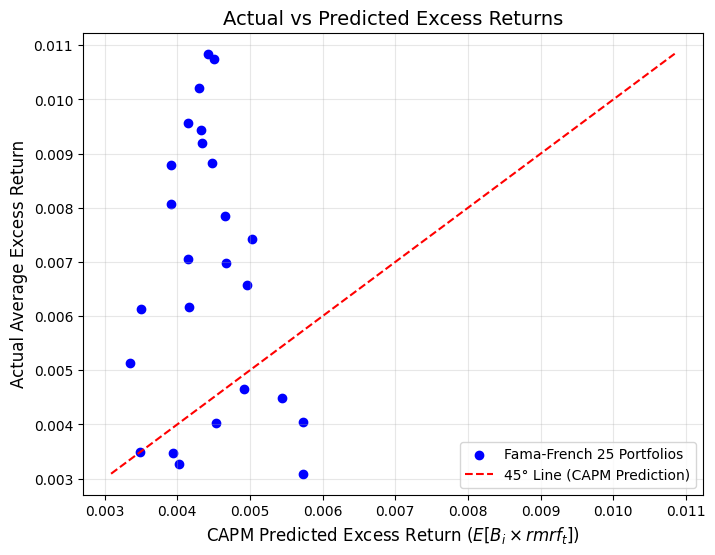

In [19]:
# | tbl-cap: "Actual vs Predicted Excess Returns"
# | label: tbl-actual-vs-predicted-exc-returns

# Predicted Returns
mkt_mean_excess = reg_data["Mkt_RF"].mean()
capm_results["Predicted Return"] = capm_results["Beta"] * mkt_mean_excess

plt.figure(figsize=(8, 6))
plt.scatter(capm_results["Predicted Return"],
            capm_results["Mean Excess Return"],
            color='blue', label='Fama-French 25 Portfolios')

min_val = min(capm_results["Predicted Return"].min(),
              capm_results["Mean Excess Return"].min()) # for 45° line
max_val = max(capm_results["Predicted Return"].max(),
              capm_results["Mean Excess Return"].max()) # for 45° line
line_coords = np.linspace(min_val, max_val, 100)
plt.plot(line_coords, line_coords, color='red',
         linestyle='--', label='45° Line (CAPM Prediction)') # plot the 45° line

plt.xlabel(
    'CAPM Predicted Excess Return ($E[B_i \\times rmrf_t]$)', fontsize=12)
plt.ylabel('Actual Average Excess Return', fontsize=12)
plt.title('Actual vs Predicted Excess Returns', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

The graph above clear shows that the model is not good at explaining cross-sectional returns.<br>
Indeed, if the CAPM was accurate, all the blue dots would lie on the 45° line (the red one). We can also try to compare actual vs predicted:
- predicted returns rely between 0.35% and 0.55% 
- actual returns are more spread, from 0.3% to 1.1% 